In [11]:
import copy

import pandas as pd
import numpy as np
import optuna
import xgboost
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline

import matplotlib
import matplotlib.pyplot as plt

tqdm.tqdm.pandas()

import sys

sys.path.append("../httpot")
from fingerprints import fingerprint_ewald_sum

In [4]:
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [5]:
data_path = "../httpot/full_featurized_data.pkl"
data = pd.read_pickle(data_path)

cols_to_drop = ['formula',
                'discovery_process (unitless)',
                'potcars (unitless)',
                'is_hubbard (unitless)',
                'energy_per_atom (eV)',
                'exfoliation_energy_per_atom (eV/atom)',
                'is_bandgap_direct (unitless)',
                'is_metal (unitless)',
                'energy_vdw_per_atom (eV/atom)',
                'total_magnetization (Bohr Magneton)']
target_column = ['bandgap (eV)']
matpedia_id = ['2dm_id (unitless)']
atoms_col = ['atoms_object (unitless)']

In [6]:
max_atoms = max(data['atoms_object (unitless)'].apply(len))
ewald_eigenspectrum = dscribe.descriptors.EwaldSumMatrix(n_atoms_max=max_atoms,
                                                         permutation='eigenspectrum',
                                                         sparse=False)
data['ewald_fingerprint'] = data['atoms_object (unitless)'].progress_apply(lambda atoms: np.real(ewald_eigenspectrum.create(atoms)))

100%|██████████| 6351/6351 [00:35<00:00, 180.04it/s]


In [7]:
bandgap_cutoff = 0.1

data['metal'] = data['bandgap (eV)'] < bandgap_cutoff
train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, stratify=data['metal'], random_state=RANDOM_SEED)

In [8]:
def get_x_y(df):
    x = np.vstack(df['ewald_fingerprint'])
    y = df['metal'].apply(int).to_numpy()
    return x,y
train_x, train_y = get_x_y(train)
test_x, test_y = get_x_y(test)

best_bg = None

def callback(study, trial):
    global best_bg
    try:
        if study.best_trial == trial:
            best_bg =1
    except ValueError:
        pass

def objective(trial: optuna.Trial):
    global best_bg
    tr_x, val_x, tr_y, val_y = sklearn.model_selection.train_test_split(train_x, train_y, test_size=0.5)
    dtrain = xgboost.DMatrix(tr_x, label=tr_y)
    dval = xgboost.DMatrix(val_x, label=val_y)

    params = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate' : trial.suggest_float('eta', 0, 1),
        'min_split_loss' : trial.suggest_float('eta', 0, 1),
        'max_depth' : trial.suggest_int('max_depth', 1, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0, 2)
    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-auc')
    best_bg = xgboost.train(params, dtrain, num_boost_round=100, early_stopping_rounds=5,
                            evals=[(dval, 'validation')], callbacks=[pruning_callback], verbose_eval=False)
    preds = best_bg.predict(dval)
    pred_labels = np.rint(preds)
    f1 = sklearn.metrics.f1_score(val_y, pred_labels)
    return f1

In [12]:
study = optuna.create_study(
    sampler = optuna.samplers.CmaEsSampler(
        restart_strategy='ipop',
        inc_popsize=2,
        seed=RANDOM_SEED,
        consider_pruned_trials=True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='maximize',
)

/Users/mat3ra/.env/lib/python3.8/site-packages/optuna/samplers/_cmaes.py:221: ExperimentalWarning: `restart_strategy` option is an experimental feature. The interface can change in the future.
  warnings.warn(
/Users/mat3ra/.env/lib/python3.8/site-packages/optuna/samplers/_cmaes.py:228: ExperimentalWarning: `consider_pruned_trials` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2021-08-04 18:20:25,376] A new study created in memory with name: no-name-5342dfab-61e3-45cd-8222-b36ca36edbbc


In [13]:
study.optimize(objective, n_trials=100, callbacks=[callback])

[I 2021-08-04 18:20:26,142] Trial 0 finished with value: 0.7064050351721584 and parameters: {'eta': 0.1915194503788923, 'max_depth': 63, 'min_child_weight': 4.377277390071145, 'reg_lambda': 1.5707171674275384, 'reg_alpha': 1.559951616237607}. Best is trial 0 with value: 0.7064050351721584.
[I 2021-08-04 18:20:26,278] Trial 1 finished with value: 0.7057505601194921 and parameters: {'eta': 0.2725926052826416, 'max_depth': 28, 'min_child_weight': 8.018721775350192, 'reg_lambda': 1.9162787073674103, 'reg_alpha': 1.7518652694841894}. Best is trial 0 with value: 0.7064050351721584.
[W 2021-08-04 18:20:26,282] The parameter 'eta' in trial#2 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is inten

In [14]:
def plot_roc(x, y):
        plt.rcParams['figure.figsize'] = [10,10]
        probabilities = best_bg.predict(xgboost.DMatrix(x))

        # ROC curve function in sklearn prefers the positive class
        false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(y, probabilities,
                                                                                        pos_label=1)
        thresholds[0] -= 1  # Sklearn arbitrarily adds 1 to the first threshold
        roc_auc = np.round(sklearn.metrics.auc(false_positive_rate, true_positive_rate), 3)

        # Plot the curve
        fig, ax = plt.subplots()
        points = np.array([false_positive_rate, true_positive_rate]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(thresholds.min(), thresholds.max())
        lc = matplotlib.collections.LineCollection(segments, cmap='jet', norm=norm, linewidths=2)
        lc.set_array(thresholds)
        line = ax.add_collection(lc)
        fig.colorbar(line, ax=ax).set_label('Threshold')

        # Padding to ensure we see the line
        ax.margins(0.01)

        fig.patch.set_facecolor('white')

        plt.plot([0,1], [0,1], c='k')

        plt.title(f"ROC curve, AUC={roc_auc}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.tight_layout()
        plt.show()

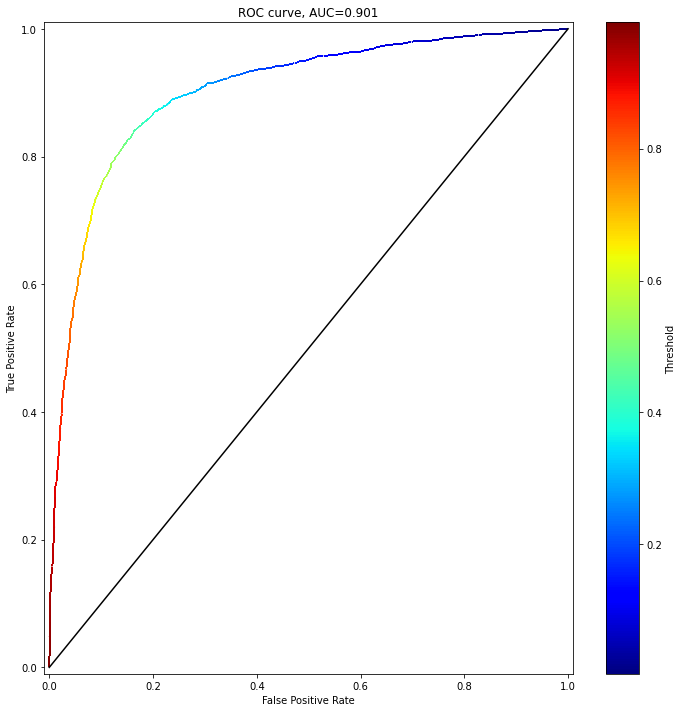

In [15]:
plot_roc(train_x, train_y)

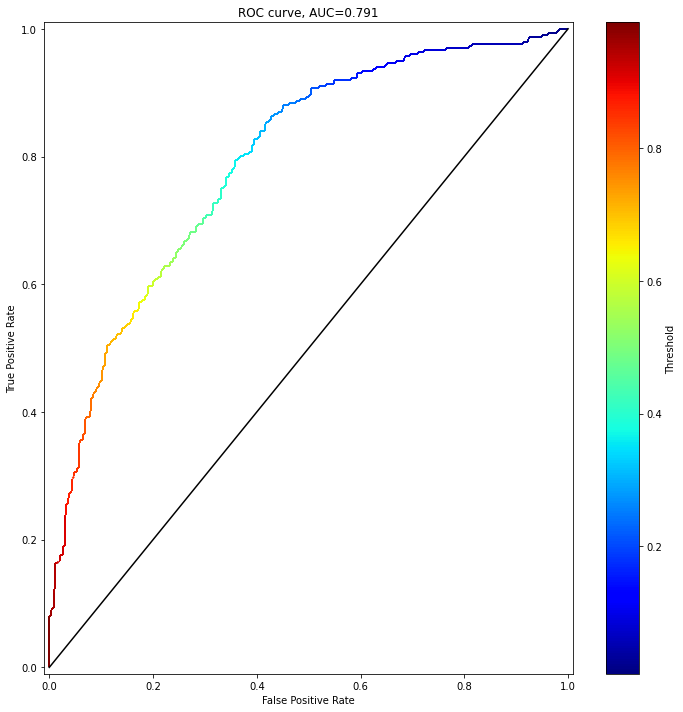

In [16]:
plot_roc(test_x, test_y)

In [29]:
#bg = xgboost.XGBClassifier().load_model('best.boost')

cutoff = 0.25
train['pred_metal'] = copy.deepcopy(best_bg.predict(xgboost.DMatrix(train_x)) > cutoff)
test['pred_metal'] = copy.deepcopy(best_bg.predict(xgboost.DMatrix(test_x)) > cutoff)

<ipython-input-29-ae09c947c0e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred_metal'] = copy.deepcopy(best_bg.predict(xgboost.DMatrix(train_x)) > cutoff)
<ipython-input-29-ae09c947c0e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_metal'] = copy.deepcopy(best_bg.predict(xgboost.DMatrix(test_x)) > cutoff)


In [30]:
train_metals = train[train['pred_metal'] == True]
train_nonmetals = train[train['pred_metal'] != True]
test_metals = test[test['pred_metal'] == True]
test_nonmetals = test[test['pred_metal'] != True]

len(train_metals)

3510

In [31]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
matminer_descriptors = [
    'bond_length_average',
    'bond_angle_average',
    'average_cn',
    'global_instability',
    'perimeter_area_ratio',
    'ewald_energy_per_atom',
    'structural complexity per atom',
    'structural complexity per cell',
    'n_symmetry_ops'

]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors#%%
target = ['bandgap (eV)']

In [32]:
train_x = train_nonmetals[xenonpy_matminer_descriptors].to_numpy()
train_y = train_nonmetals[target].to_numpy()

test_x = test_nonmetals[xenonpy_matminer_descriptors].to_numpy()
test_y = test_nonmetals[target].to_numpy()

In [33]:
model = xgboost.sklearn.XGBRegressor(
    alpha=0.99,
    learning_rate=0.1,
    max_depth=3,
    max_features=0.1,
    min_samples_leaf=3,
    min_samples_split=5,
    n_estimators=640,
    subsample=0.8500000000000001
)
model.fit(X=train_x, y=train_y)

XGBRegressor(alpha=0.99, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3, max_features=0.1,
             min_child_weight=1, min_samples_leaf=3, min_samples_split=5,
             missing=nan, monotone_constraints='()', n_estimators=640,
             n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0.99000001, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8500000000000001, tree_method='exact',
             validate_parameters=1, verbosity=None)

/Users/mat3ra/.env/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


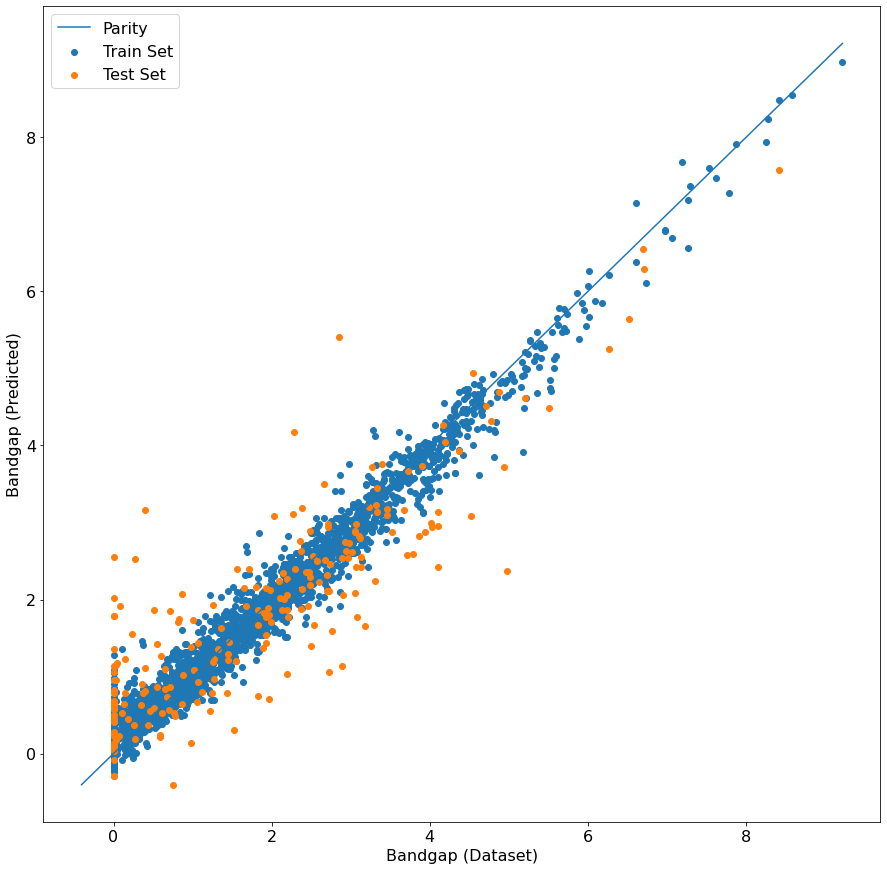

In [34]:
y_pred_train = model.predict(train_x)
y_pred_test = model.predict(test_x)

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams["font.size"] = 16

plt.scatter(x=train_y, y=y_pred_train, label="Train Set")
plt.scatter(x=test_y, y=y_pred_test, label="Test Set")

min_xy = min(min(test_y), min(train_y), min(y_pred_test), min(y_pred_train))
max_xy = max(max(test_y), max(train_y), max(y_pred_test), max(y_pred_train))

plt.plot([min_xy, max_xy], [min_xy, max_xy], label="Parity")
plt.ylabel("Bandgap (Predicted)")
plt.xlabel("Bandgap (Dataset)")
plt.legend()
plt.savefig('plot.jpeg')

In [36]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=y_pred_test)
    print(key,value)

MaxError 2.7655151813507084
MAE 0.5827037463572136
MSE 0.6292347053881026
RMSE 0.7932431565340495
MAPE 417838819259799.7
R2 0.7535522443864033
